# Import packages, define functions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import metcalc
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
#import xesmf as xe
from sklearn.feature_selection import mutual_info_regression

In [2]:
def anomaly_from_tropical_mean(ds, lat=20) :
    return ds.sel(lat=slice(-lat,lat)) - metcalc.xr_fldmean(ds.sel(lat=slice(-lat,lat)))

In [3]:
def format_dataset(ds) :
    ds.coords['plev2'] = ds.plev / 100.
    ds = ds.swap_dims({'plev': 'plev2'}).squeeze(drop='true')
    return ds

In [4]:
def read_sims_same_e(name,dap_LR,epsilons=[0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2],f="gill",res=2,lat_extent=30) :
    sims_list = []
    used_epsilons =[]
    for e in epsilons :
        full_name = name + f"epsilon_p={e}_epsilon_u={e}_epsilon_v={e}_f={f}_res={res}.nc"

        if os.path.isfile(full_name) :
            sims_list.append(xr.open_dataset(full_name))
            used_epsilons.append(e)
    
    if len(used_epsilons) == 0 :
        print(f"no simulations found for {name}")
        return
    
    sims = xr.concat(sims_list,xr.DataArray(used_epsilons,coords=[used_epsilons], dims=["epsilon"]))
    # - select 20N-20S
    # - get rid of boundaries... (1sr and last index)
    if lat_extent == 20 :
        sims_20 = sims.isel(x=slice(1,-1),y=slice(1,-1)) 
    else :
        sims_20 = sims.isel(x=slice(1,-1),y=slice(6,26)) # for 2x2 res
    
    sims_20 = sims_20.assign_coords(lon = ("x", dap_LR.lon.values)).assign_coords(lat = ("y", dap_LR.lat.values))
    sims_20 = sims_20.swap_dims({"x": "lon"}).swap_dims({"y": "lat"})
    return sims_20

In [5]:
def read_sims(name,dap_LR,epsilons=[0.0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2],f="gill",res=2,lat_extent=30) :
    sims_list = []
    used_ep =[]
    
    for ep in epsilons :
        used_ev = []
        sims_ev_list = []
        for ev in epsilons :
            full_name = name + f"epsilon_p={ep}_epsilon_u={ev}_epsilon_v={ev}_f={f}_res={res}.nc"
            if os.path.isfile(full_name) :
                sims_ev_list.append(xr.open_dataset(full_name))
                used_ev.append(ev)
        if len(sims_ev_list) > 0 :
            sims_list.append(xr.concat(sims_ev_list,xr.DataArray(used_ev,coords=[used_ev], dims=["epsilon_wind"])))
            used_ep.append(ep)
        
    all_sims = xr.concat(sims_list,xr.DataArray(used_ep,coords=[used_ep], dims=["epsilon_pre"]))
    
    # - select 20N-20S
    # - get rid of boundaries... (1sr and last index)
    if lat_extent == 20 :
        sims_20 = all_sims.isel(x=slice(1,-1),y=slice(1,-1)) 
    else :
        sims_20 = all_sims.isel(x=slice(1,-1),y=slice(6,26)) # for 2x2 res
    
    sims_20 = sims_20.assign_coords(lon = ("x", dap_LR.lon.values)).assign_coords(lat = ("y", dap_LR.lat.values))
    sims_20 = sims_20.swap_dims({"x": "lon"}).swap_dims({"y": "lat"})
    return sims_20

In [6]:
def correlations_same_e(sim,dap_diff_an_LR,corr_lat1=-20,corr_lat2=10) :
    
    all_epsilons = sim.epsilon.values
    
    # index 0: corr 700-200 layer thickness
    #index 1: corr 400-150 layer thickness
    # index 2: corr Phi
    # index 3 MI 700-200
    # index 4: MI 400-150
    # index 5: corr 700-400
    correlation_values = np.zeros((len(all_epsilons),6))

    lons_ = dap_diff_an_LR.isel(lon=[0,-1]).lon.values
    lons=lons_

    for i,epsilon in enumerate(all_epsilons) :
        sims_20_upper_trop_an = anomaly_from_tropical_mean(sim.sel(epsilon=epsilon))
        p_corr = sims_20_upper_trop_an["p"].sel(lat=slice(corr_lat1,corr_lat2)).values.flatten()
        corr_700 = np.corrcoef(p_corr,dap_diff_an_LR["700_200_thick"].sel(lat=slice(corr_lat1,corr_lat2)).values.flatten())[1,0]
        corr_400_150 = np.corrcoef(p_corr,dap_diff_an_LR["400_150_thick"].sel(lat=slice(corr_lat1,corr_lat2)).values.flatten())[1,0]
        corr_Phi = np.corrcoef(p_corr,dap_diff_an_LR["Phi"].sel(lat=slice(corr_lat1,corr_lat2)).sel(plev2=200).values.flatten())[1,0]
        corr_700_400 = np.corrcoef(p_corr,dap_diff_an_LR["700_400_thick"].sel(lat=slice(corr_lat1,corr_lat2)).values.flatten())[1,0]
        MI_700 = float(mutual_info_regression(p_corr.reshape(-1, 1), dap_diff_an_LR["700_200_thick"].sel(lat=slice(corr_lat1,corr_lat2)).values.flatten()))
        MI_400_150 = float(mutual_info_regression(p_corr.reshape(-1, 1), dap_diff_an_LR["400_150_thick"].sel(lat=slice(corr_lat1,corr_lat2)).values.flatten()))

        correlation_values[i,:] = np.array([corr_700,corr_400_150,corr_Phi,MI_700,MI_400_150,corr_700_400])
                
    return correlation_values


In [7]:
def correlations(sim,dap_diff_an_LR,corr_lat1=-20,corr_lat2=10) :
    
    sims_an = anomaly_from_tropical_mean(sim) # dont really need this...
    
    sim_stacked = sims_an.sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lon","lat"))
    dap_diff_an_stacked = dap_diff_an_LR.sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lon", "lat"))
    
    corr = xr.corr(sim_stacked.p,dap_diff_an_stacked["700_200_thick"],dim="coord").to_dataset(name="700_200_thick")
    corr["400_200_thick"] = xr.corr(sim_stacked.p,dap_diff_an_stacked["400_200_thick"],dim="coord")
    corr["400_150_thick"] = xr.corr(sim_stacked.p,dap_diff_an_stacked["400_150_thick"],dim="coord")

    return corr


In [8]:
def RMSE(a,b) :    
    return np.sqrt(np.sum((a.flatten()-b.flatten())**2)/np.shape(a.flatten()))

In [9]:
def xr_RMSE(sim,dap_diff_LR,dims=["lon","lat"],lat1=-20,lat2=10) :
    
    assert type(dims) == list, "dims must be list"
    
    return xr.apply_ufunc(RMSE,
        sim.sel(lat=slice(lat1,lat2)),
        dap_diff_LR.sel(lat=slice(lat1,lat2)),
        input_core_dims=[dims, dims],
        dask='parallelized',
        output_dtypes=[float],
        vectorize=True)
    
    

In [10]:
def xr_RMSE2(sim,dap_diff_LR,dims=["coord"],lat1=-20,lat2=10) :
    
    assert type(dims) == list, "dims must be list"
    
    a = sim.sel(lat=slice(lat1,lat2)).stack(coord=("lon", "lat"))
    b = dap_diff_LR.sel(lat=slice(lat1,lat2)).stack(coord=("lon", "lat"))
    
    return xr.apply_ufunc(RMSE,
        a, b,
        input_core_dims=[dims, dims],
        dask='parallelized',
        output_dtypes=[float],
        vectorize=True)
    
    

In [11]:
def read_mm_files(filenames,index=74) :
    def preproc(ds):
        filename = ds.encoding['source']
        month=filename[index]
        if 'plev' in ds.coords :
            ds.coords['plev2'] = ds.plev / 100
            ds = ds.swap_dims({'plev': 'plev2'})
            ds.plev2['units'] = 'hPa'
        ds['month'] = int(month)
        return ds

    return xr.open_mfdataset(filenames,concat_dim="month", combine='nested',preprocess=preproc)

In [12]:
def calc_MI(sim_an,GCM_diff_an,corr_lat1=-20,corr_lat2=10,warning=False) :
    
    p_corr = sim_an["p"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon"))
    GCM_corr_400_150 = GCM_diff_an["400_150_thick"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon"))
    GCM_corr_400_200 = GCM_diff_an["400_200_thick"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon"))
    GCM_corr_700_200 = GCM_diff_an["700_200_thick"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon"))
    
    MI = metcalc.xr_MI(p_corr,GCM_corr_400_150,"coord").to_dataset(name="400_150_thick")
    MI["400_200_thick"] = metcalc.xr_MI(p_corr,GCM_corr_400_200,"coord")
    MI["700_200_thick"] = metcalc.xr_MI(p_corr,GCM_corr_700_200,"coord")

    return MI.compute()


# Read Files

## Perpetual January

In [13]:
WORK_DIR="/work/mh0066/m300577/perpetual_jan"

In [14]:
dap0013_ta = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ta_20N-20S_19790[2-9]_timemean.nc",index=73)
dap0014_ta = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ta_20N-20S_19790[2-9]_timemean.nc",index=73)
dap0013_ta["hus"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_hus_20N-20S_19790[2-9]_timemean.nc").hus
dap0014_ta["hus"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_hus_20N-20S_19790[2-9]_timemean.nc").hus
dap0013_ta["Tv"] = metcalc.virtual_temperature(dap0013_ta.ta,dap0013_ta.hus)
dap0014_ta["Tv"] = metcalc.virtual_temperature(dap0014_ta.ta,dap0014_ta.hus)

In [15]:
dap0013_ta["700_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,700,200)
dap0014_ta["700_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,700,200)
dap0013_ta["700_200_thick_ta"] = metcalc.xr_thickness(dap0013_ta.ta,700,200)
dap0014_ta["700_200_thick_ta"] = metcalc.xr_thickness(dap0014_ta.ta,700,200)
dap0013_ta["400_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,400,200)
dap0014_ta["400_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,400,200)
dap0013_ta["400_150_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,400,150)
dap0014_ta["400_150_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,400,150)
dap0013_ta["500_150_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,500,150)
dap0014_ta["500_150_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,500,150)
dap0013_ta["700_400_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,700,400)
dap0014_ta["700_400_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,700,400)
dap0013_ta["Phi"] = metcalc.xr_geopotential(dap0013_ta.Tv).Phi
dap0014_ta["Phi"] = metcalc.xr_geopotential(dap0014_ta.Tv).Phi


In [16]:
dap0013_ta_LR = dap0013_ta.coarsen(lon=20, lat=20).mean()
dap0014_ta_LR = dap0014_ta.coarsen(lon=20, lat=20).mean()

In [17]:
dap_diff = dap0014_ta.mean("month") - dap0013_ta.mean("month")
dap_diff_LR = dap0014_ta_LR.mean("month") - dap0013_ta_LR.mean("month")

dap_diff_an = anomaly_from_tropical_mean(dap_diff.compute())
dap_diff_an_LR = anomaly_from_tropical_mean(dap_diff_LR.compute())

## Numerical Gill

In [18]:
GILL_DIR="/work/mh0066/m300577/numerical_gill/data"

In [19]:
epsilons = [0.0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2]

In [20]:
delta_p_same_e_len1 = read_sims_same_e(f"{GILL_DIR}/sims_monte_carlo_400-150/delta_pr_non_dim_400-150_30N-30S_",
                                       dap_diff_LR,
                                       epsilons=[0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2])


In [21]:
delta_p_same_e_FFT = read_sims_same_e(f"{GILL_DIR}/sims_monte_carlo_400-150_FFT/delta_pr_non_dim_400-150_30N-30S_FFT_",
                                       dap_diff_LR,
                                       epsilons=[0,0.005,0.01,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2.0,5.0,10.0])


In [22]:
delta_p_same_e_comp = read_sims_same_e(f"{GILL_DIR}/sims_monte_carlo_400-150_zon_comp/delta_pr_non_dim_400-150_zon_comp_30N-30S_",
                                       dap_diff_LR,
                                       epsilons=[0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2])


In [23]:
delta_p_len1 = read_sims(f"{GILL_DIR}/sims_monte_carlo_400-150/delta_pr_non_dim_400-150_30N-30S_",
                                       dap_diff_LR,
                                       epsilons=[0.0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2])

In [24]:
delta_p_comp = read_sims(f"{GILL_DIR}/sims_monte_carlo_400-150_zon_comp/delta_pr_non_dim_400-150_zon_comp_30N-30S_",
                                       dap_diff_LR,
                                       epsilons=[0.0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2])

In [25]:
delta_p_FFT = read_sims(f"{GILL_DIR}/sims_monte_carlo_400-150_FFT/delta_pr_non_dim_400-150_30N-30S_FFT_",
                                       dap_diff_LR,
                                       epsilons=[0,0.005,0.01,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2.0,5.0,10.0],
                             )


In [26]:
p_FFT_early = read_sims(f"{GILL_DIR}/sims_monte_carlo_400-150_FFT_early/pr_early_non_dim_400-150_30N-30S_FFT_",
                                       dap_diff_LR,
                                       epsilons=[0,0.005,0.01,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2.0,5.0,10.0],
                             )


In [27]:
p_FFT_late = read_sims(f"{GILL_DIR}/sims_monte_carlo_400-150_FFT_late/pr_late_non_dim_400-150_30N-30S_FFT_",
                                       dap_diff_LR,
                                       epsilons=[0,0.005,0.01,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5,2.0,5.0,10.0],
                             )


In [28]:
delta_p_FFT_ind = p_FFT_late - p_FFT_early

In [29]:
delta_p_atl = read_sims(f"{GILL_DIR}/sims_monte_carlo_special/delta_pr_atl_non_dim_30N-30S_",dap_diff_LR)
delta_p_wpac = read_sims(f"{GILL_DIR}/sims_monte_carlo_special/delta_pr_wpac_non_dim_30N-30S_",dap_diff_LR)
delta_p_thermo = read_sims(f"{GILL_DIR}/sims_monte_carlo_special/delta_pr_thermo_non_dim_20N-20S_",dap_diff_LR,lat_extent=20)
delta_p_dyn = read_sims(f"{GILL_DIR}/sims_monte_carlo_special/delta_pr_dynamic_non_dim_20N-20S_",dap_diff_LR,lat_extent=20)

In [30]:
delta_p_len1["dp/dx"] = metcalc.x_derivative(delta_p_len1.p)
delta_p_len1["dp/dy"] = metcalc.y_derivative(delta_p_len1.p)
delta_p_FFT["dp/dx"] = metcalc.x_derivative(delta_p_FFT.p)
delta_p_FFT["dp/dy"] = metcalc.y_derivative(delta_p_FFT.p)

In [31]:
corrs_same_e_len1 = correlations_same_e(delta_p_same_e_len1,dap_diff_an_LR,corr_lat1=-20,corr_lat2=10)
corrs_same_e_FFT = correlations_same_e(delta_p_same_e_FFT,dap_diff_an_LR,corr_lat1=-20,corr_lat2=10)
corrs_same_e_comp = correlations_same_e(delta_p_same_e_comp,dap_diff_an_LR,corr_lat1=-20,corr_lat2=10)

In [32]:
corrs_len1 = correlations(delta_p_len1,dap_diff_an_LR)
corrs_comp = correlations(delta_p_comp,dap_diff_an_LR)


In [33]:
corrs_FFT = correlations(delta_p_FFT,dap_diff_an_LR)
corrs_FFT_ind = correlations(delta_p_FFT_ind,dap_diff_an_LR)

In [34]:
RMSE_FFT = xr_RMSE(delta_p_FFT["p"]* 2800.,dap_diff_LR["400_150_thick"]).compute()
RMSE_FFT_an = xr_RMSE(anomaly_from_tropical_mean(delta_p_FFT["p"])* 2800.,dap_diff_an_LR["400_150_thick"]).compute()

In [35]:
corrs_atl_forced = correlations(delta_p_atl,dap_diff_an_LR)
corrs_wpac_forced = correlations(delta_p_wpac,dap_diff_an_LR)


In [36]:
MI = calc_MI(delta_p_len1,dap_diff_an_LR)
MI_comp = calc_MI(delta_p_comp,dap_diff_an_LR)
MI_FFT = calc_MI(delta_p_FFT,dap_diff_an_LR)
MI_FFT_ind = calc_MI(delta_p_FFT_ind,dap_diff_an_LR)


In [37]:
corrs_FFT_late = correlations(p_FFT_late,dap0014_ta_LR.mean("month").compute())
corrs_FFT_early = correlations(p_FFT_early,dap0013_ta_LR.mean("month").compute())

# Plot

In [38]:
plt.rc('text',  usetex=False)
plt.rc('font',size=12)
!mkdir -p ../plots

In [39]:
max_ = corrs_FFT["400_150_thick"].argmax(...)
max_da = corrs_FFT["400_150_thick"].isel(epsilon_pre = max_["epsilon_pre"].values,epsilon_wind = max_["epsilon_wind"].values)

## Correlations, MI, RMSE

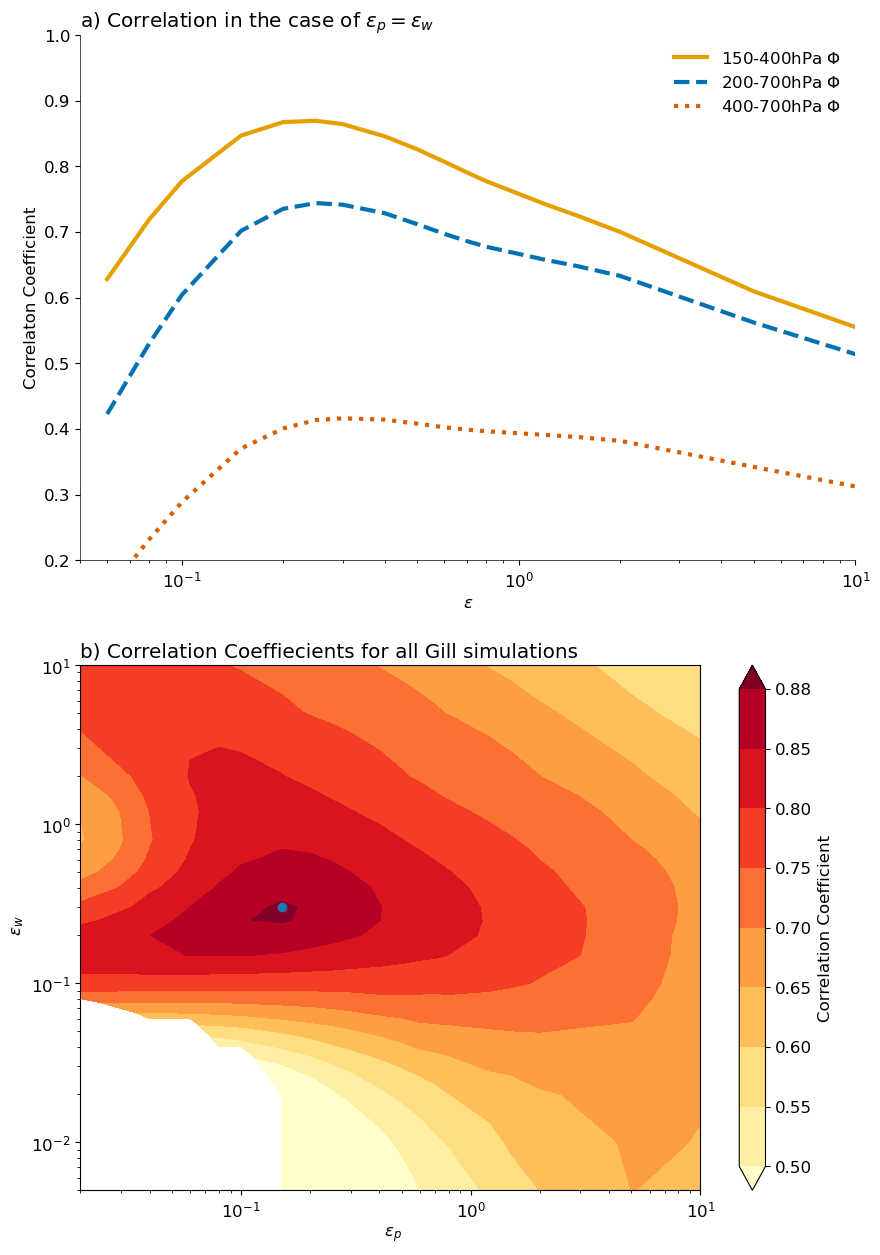

In [48]:
fig,xs = plt.subplots(2,1,figsize=(10,15),facecolor="white")

ax=xs[0]
ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,1], color=metcalc.collist[1],label = "150-400hPa $\Phi$",linewidth=3)
ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,0], color=metcalc.collist[3],label = "200-700hPa $\Phi$",ls="--",linewidth=3)
ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,5], color=metcalc.collist[4],label = "400-700hPa $\Phi$",ls=":",linewidth=3)
ax.set_xlim(0.05,10)
ax.set_ylim(0.2,1)
ax.set_xlabel("$\epsilon$")
ax.set_xscale('log')


ax.set_ylabel(r"Correlaton Coefficient")
ax.legend(frameon=False)

metcalc.remove_axes(ax)
ax.set_title("a) Correlation in the case of $\epsilon_p = \epsilon_w$ ",loc="left") 

corrs_plot = corrs_len1
corrs_plot.coords["epsilon_pre"] = corrs_plot.coords["epsilon_pre"]# + 1.
corrs_plot.coords["epsilon_wind"] = corrs_plot.coords["epsilon_wind"]# + 1.

ax=xs[1]
im = corrs_FFT["400_150_thick"].plot.contourf(x="epsilon_pre",y="epsilon_wind",vmin=0.5,vmax=0.9,ax=ax,
                                              levels=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.88],
                                              cbar_kwargs={"label": "Correlation Coefficient"},
                                              cmap="YlOrRd")
ax.scatter(max_da.epsilon_pre,max_da.epsilon_wind)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)

ax.set_xlabel(" $\epsilon_p$")
ax.set_ylabel(" $\epsilon_w$")


ax.set_title("b) Correlation Coeffiecients for all Gill simulations",loc="left") 

plt.savefig('../plots/figure5.png', dpi=600,bbox_inches='tight')


Text(0.0, 1.0, 'b) MI Coeffiecients for all Gill simulations')

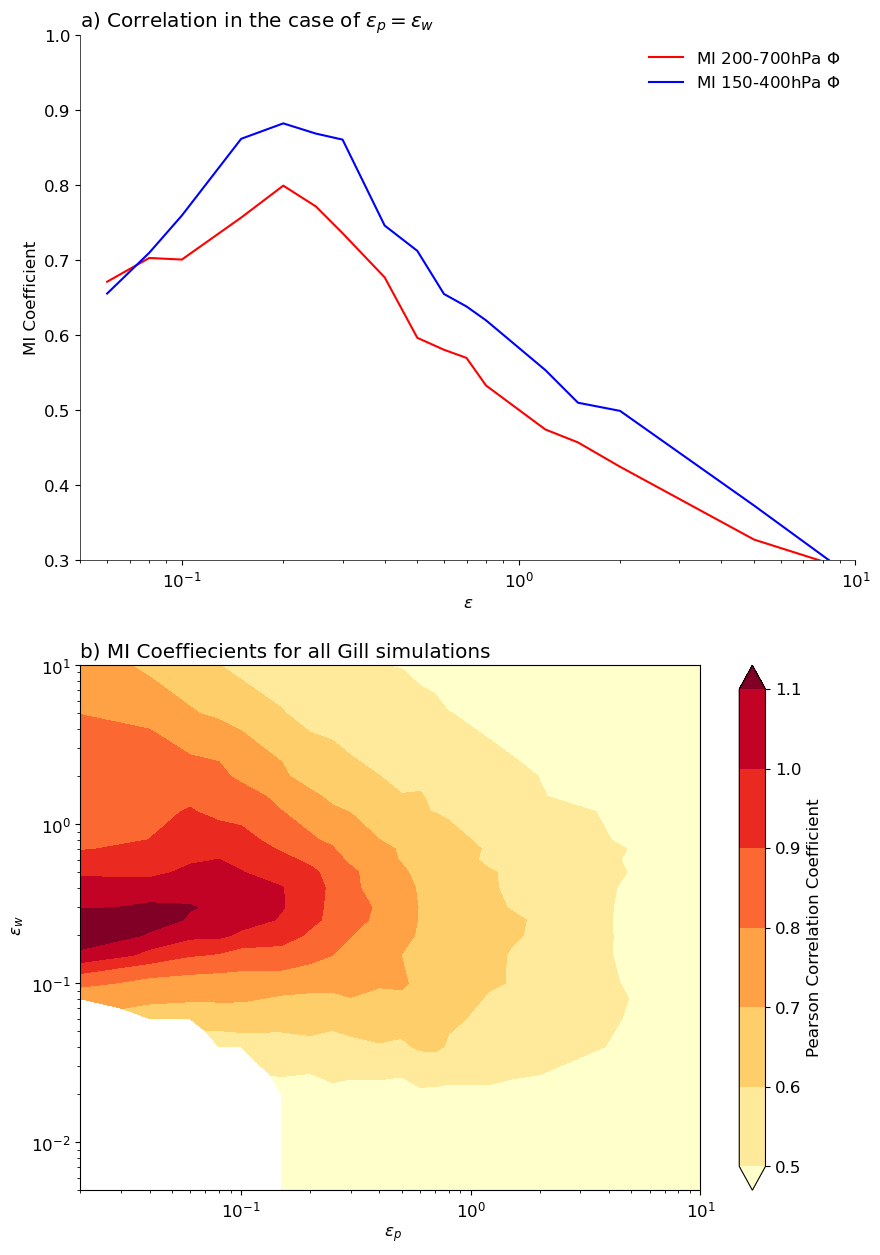

In [41]:
fig,xs = plt.subplots(2,1,figsize=(10,15),facecolor="white")

ax=xs[0]
#ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,0], color="red",label = "correlation 200-700hPa $\Phi$")
#ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,1], color="blue",label = "correlation 150-400hPa $\Phi$")
ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,3], color="red",label = "MI 200-700hPa $\Phi$")
ax.plot(delta_p_same_e_FFT.epsilon.values, corrs_same_e_FFT[:,4], color="blue",label = "MI 150-400hPa $\Phi$")
ax.set_xlim(0.05,10)
ax.set_ylim(0.3,1)
#ax.set_xlabel(r"$\displaystyle \epsilon$")
ax.set_xlabel("$\epsilon$")
ax.set_xscale('log')


ax.set_ylabel(r"MI Coefficient")
ax.legend(frameon=False)

metcalc.remove_axes(ax)
ax.set_title("a) Correlation in the case of $\epsilon_p = \epsilon_w$ ",loc="left") 

corrs_plot = corrs_len1
corrs_plot.coords["epsilon_pre"] = corrs_plot.coords["epsilon_pre"]# + 1.
corrs_plot.coords["epsilon_wind"] = corrs_plot.coords["epsilon_wind"]# + 1.

ax=xs[1]
im = MI_FFT["400_150_thick"].plot.contourf(x="epsilon_pre",y="epsilon_wind",vmin=0.5,vmax=1.1,cmap="YlOrRd",
                                           cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)

ax.set_xlabel(" $\epsilon_p$")
ax.set_ylabel(" $\epsilon_w$")


ax.set_title("b) MI Coeffiecients for all Gill simulations",loc="left") 


Text(0.0, 1.0, 'RMSE')

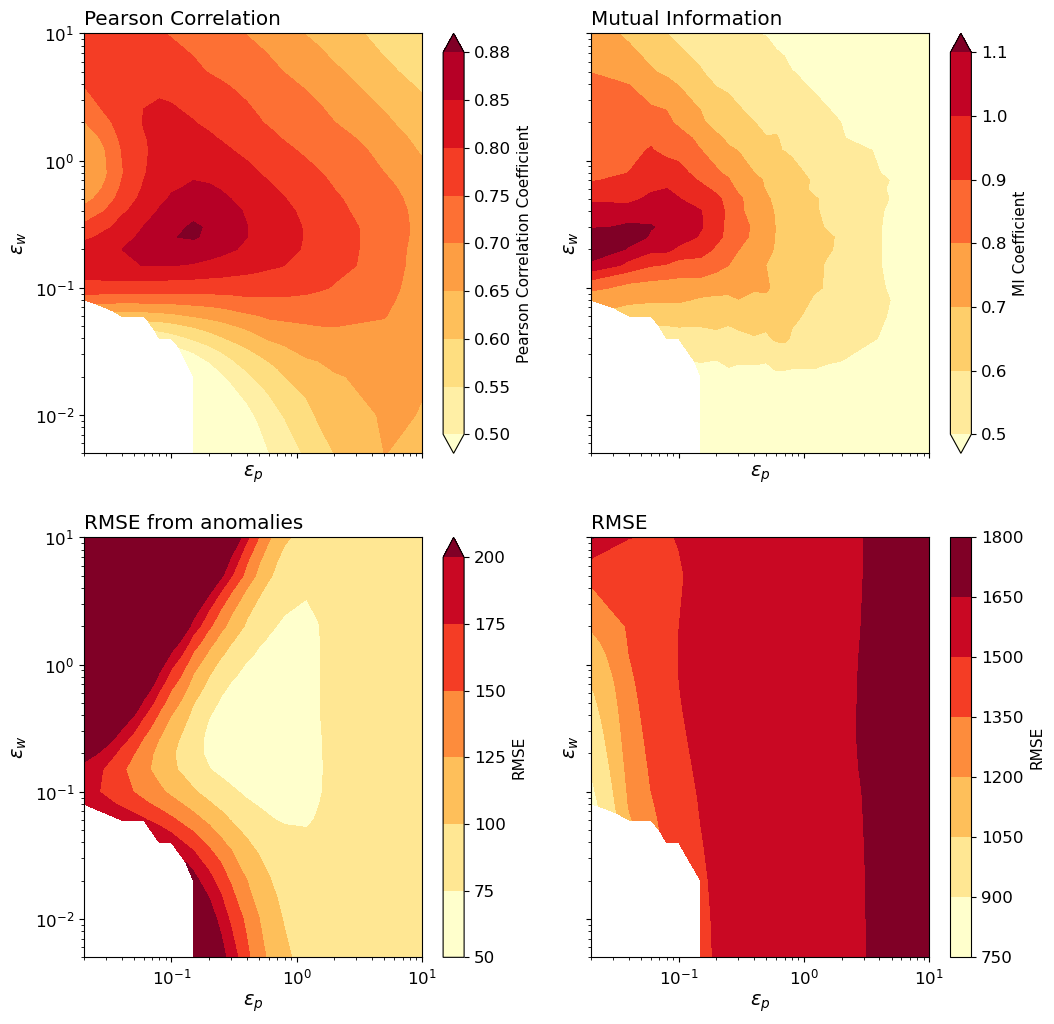

In [42]:
fig,xs = plt.subplots(2,2,figsize=(12,12),facecolor="white",sharex=True,sharey=True)

ax=xs[0,0]
im = corrs_FFT["400_150_thick"].plot.contourf(x="epsilon_pre",y="epsilon_wind",vmin=0.5,vmax=0.9,cmap="YlOrRd",
                                              cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax,
                                             levels=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.88])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$",size=14)
ax.set_ylabel("$\epsilon_w$",size=14)

im.colorbar.set_label('Pearson Correlation Coefficient',size=11)
ax.set_title("Pearson Correlation",loc="left") 


ax=xs[0,1]
im = MI_FFT["400_150_thick"].plot.contourf(x="epsilon_pre",y="epsilon_wind",vmin=0.5,vmax=1.1,cmap="YlOrRd",cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$",size=14)
ax.set_ylabel("$\epsilon_w$",size=14)

im.colorbar.set_label('MI Coefficient',size=11)

ax.set_title("Mutual Information",loc="left") 


ax=xs[1,0]
im = RMSE_FFT_an.plot.contourf(x="epsilon_pre",y="epsilon_wind",vmin=50,vmax=200,cmap="YlOrRd",cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$",size=14)
ax.set_ylabel("$\epsilon_w$",size=14)

im.colorbar.set_label('RMSE',size=11)

ax.set_title("RMSE from anomalies",loc="left") 

ax=xs[1,1]
im = RMSE_FFT.plot.contourf(x="epsilon_pre",y="epsilon_wind",cmap="YlOrRd",cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$",size=14)
ax.set_ylabel("$\epsilon_w$",size=14)

im.colorbar.set_label('RMSE',size=11)

ax.set_title("RMSE",loc="left") 

### Zonaly compensated forcing

Text(0.0, 1.0, 'b) Correlation coeffiecients for all Gill simulations')

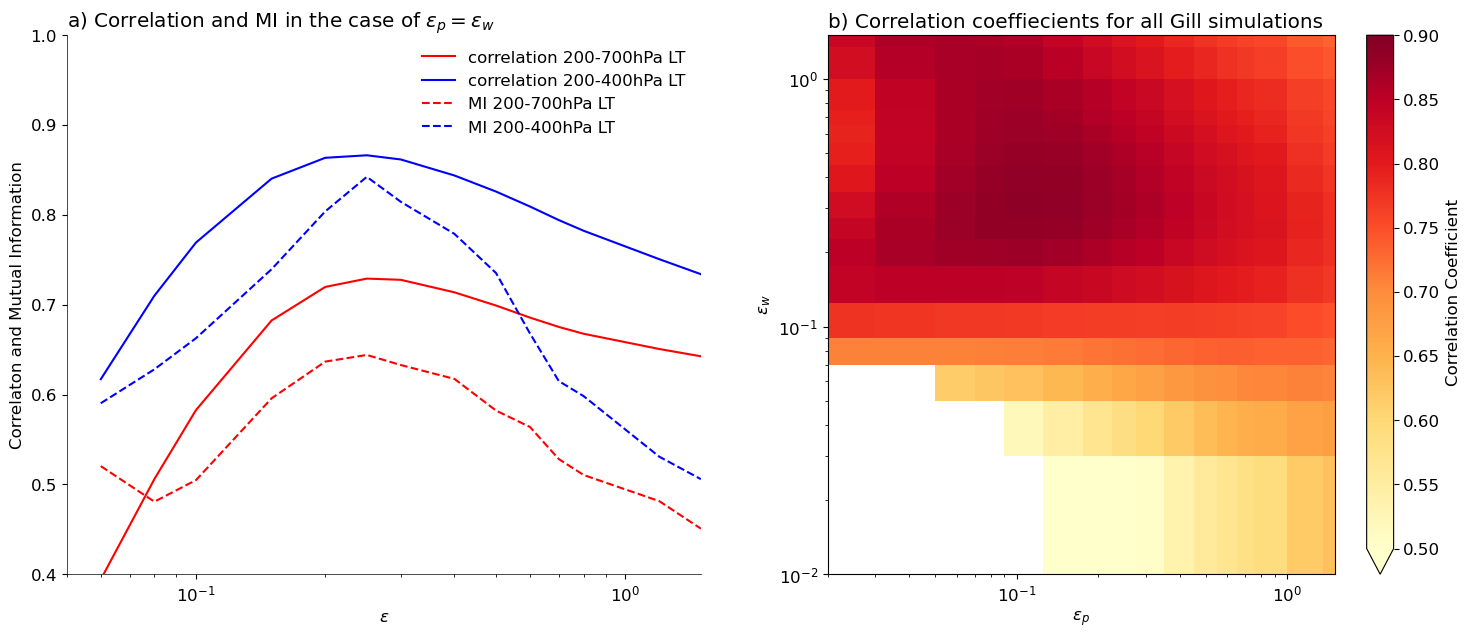

In [44]:
fig,xs = plt.subplots(1,2,figsize=(18,7),facecolor="white")

ax=xs[0]
ax.plot(delta_p_same_e_comp.epsilon.values, corrs_same_e_comp[:,0], color="red",label = "correlation 200-700hPa LT")
ax.plot(delta_p_same_e_comp.epsilon.values, corrs_same_e_comp[:,1], color="blue",label = "correlation 200-400hPa LT")
ax.plot(delta_p_same_e_comp.epsilon.values, corrs_same_e_comp[:,3], color="red",ls="--",label = "MI 200-700hPa LT")
ax.plot(delta_p_same_e_comp.epsilon.values, corrs_same_e_comp[:,4], color="blue",ls="--",label = "MI 200-400hPa LT")
ax.set_ylim(0.4,1)
#ax.set_xlabel(r"$\displaystyle \epsilon$")
ax.set_xlabel("$\epsilon$")
ax.set_xlim(0.05,1.5)
ax.set_xscale('log')

ax.set_ylabel(r"Correlaton and Mutual Information")
ax.legend(frameon=False)

metcalc.remove_axes(ax)
ax.set_title("a) Correlation and MI in the case of $\epsilon_p = \epsilon_w$ ",loc="left") 


ax=xs[1]
corrs_comp["400_150_thick"].plot(x="epsilon_pre",y="epsilon_wind",vmin=0.5,vmax=0.9,cmap="YlOrRd",cbar_kwargs={"label": "Correlation Coefficient"},ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.02,1.5)
ax.set_ylim(0.01,1.5)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$")
ax.set_ylabel("$\epsilon_w$")

ax.set_title("b) Correlation coeffiecients for all Gill simulations",loc="left") 



### Eraly vs Late 21st century

In [46]:
max_early = corrs_FFT_early["400_150_thick"].argmax(...)
max_late = corrs_FFT_late["400_150_thick"].argmax(...)
max_early_da = corrs_FFT_early["400_150_thick"].isel(epsilon_pre = max_early["epsilon_pre"].values,epsilon_wind = max_early["epsilon_wind"].values)
max_late_da = corrs_FFT_late["400_150_thick"].isel(epsilon_pre = max_late["epsilon_pre"].values,epsilon_wind = max_late["epsilon_wind"].values)


In [47]:
max_early_da

<xarray.DataArray '400_150_thick' ()>
array(0.91830141)
Coordinates:
    epsilon_wind  float64 0.08
    epsilon_pre   float64 0.1

In [48]:
max_late_da

<xarray.DataArray '400_150_thick' ()>
array(0.93845923)
Coordinates:
    epsilon_wind  float64 0.1
    epsilon_pre   float64 0.1

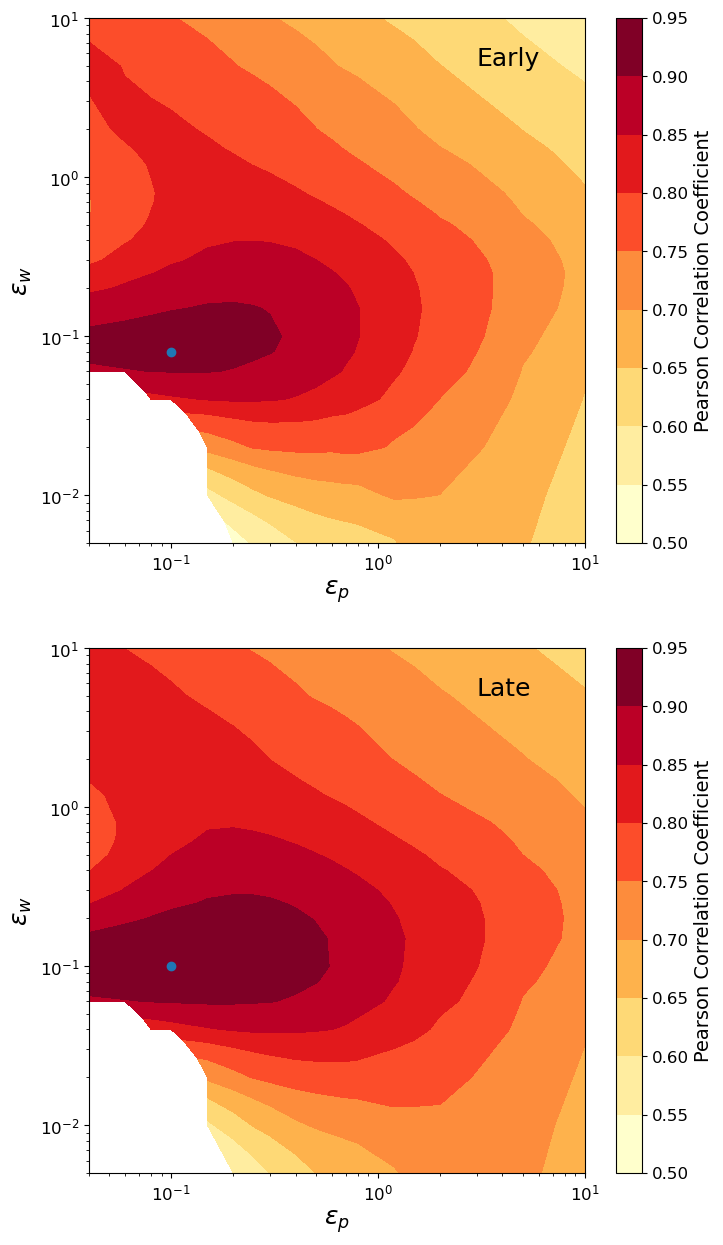

In [49]:
fig,xs = plt.subplots(2,1,figsize=(8,15),facecolor="white")

ax=xs[0]
im = corrs_FFT_early["400_150_thick"].plot.contourf(x="epsilon_pre",y="epsilon_wind",cmap="YlOrRd",
                                              cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax,
                                            levels=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
                                          )
ax.scatter(max_early_da.epsilon_pre,max_early_da.epsilon_wind)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)
ax.text(3,5,"Early",size=18)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$",size=18)
ax.set_ylabel("$\epsilon_w$",size=18)

im.colorbar.set_label('Pearson Correlation Coefficient',size=14)

ax=xs[1]
im = corrs_FFT_late["400_150_thick"].plot.contourf(x="epsilon_pre",y="epsilon_wind",cmap="YlOrRd",cbar_kwargs={"label": "Pearson Correlation Coefficient"},ax=ax,
                                                  levels=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
ax.scatter(max_late_da.epsilon_pre,max_late_da.epsilon_wind)


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.005,10)
ax.text(3,5,"Late",size=18)

#ax.set_xlabel(r"$\displaystyle \epsilon_p$")
#ax.set_ylabel(r"$\displaystyle \epsilon_w$")

ax.set_xlabel("$\epsilon_p$",size=18)
ax.set_ylabel("$\epsilon_w$",size=18)

im.colorbar.set_label('Pearson Correlation Coefficient',size=14)

plt.savefig('../plots/gill_correlations_individual.png', dpi=600,bbox_inches='tight')



# Plot Maps

Redimensionalise first:

In [50]:
delta_p_len1_an = anomaly_from_tropical_mean(delta_p_len1)
delta_p_FFT_an = anomaly_from_tropical_mean(delta_p_FFT)
delta_p_FFT_ind_an = anomaly_from_tropical_mean(delta_p_FFT_ind)

delta_p_len1_an_phi = delta_p_len1_an * 2800.
delta_p_len1_Phi = delta_p_len1 * 2800.
delta_p_FFT_an_phi = delta_p_FFT_an * 2800.
delta_p_FFT_ind_an_phi = delta_p_FFT_ind_an * 2800.
delta_p_ep01_FFT = delta_p_FFT.sel(epsilon_pre=0.1) * 2800.

delta_p_FFT_an_phi_700 = delta_p_FFT_an * 4500.
delta_p_FFT_Phi_700 = delta_p_FFT * 4500.

Text(0.88, 0.45, '$ \\Phi \\quad / \\quad m^2 s^-2 $')

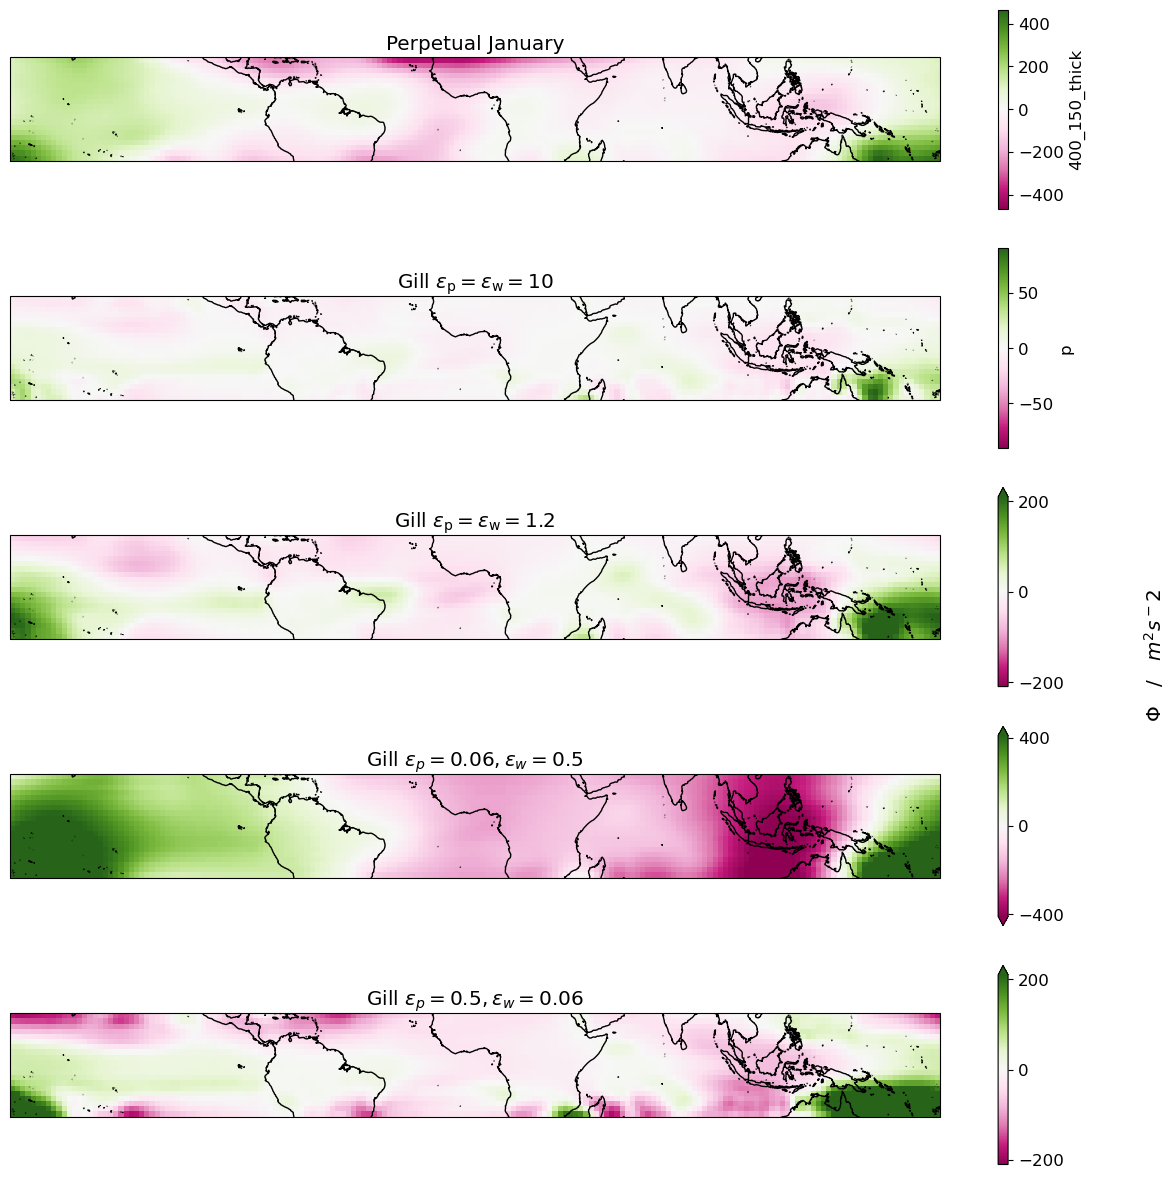

In [51]:
fig,xs = plt.subplots(5,1,figsize=(15,15), subplot_kw={'projection': ccrs.PlateCarree()},facecolor="white")

ax = xs[0]
im =  dap_diff_an_LR["400_150_thick"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True)
contor = dap_diff_an_LR.coarsen(lon=5, lat=5).mean()
#ax.contour(contor.lon.values, contor.lat.values, contor["400_200_thick"], [0],colors="black")
ax.set_title("Perpetual January")
metcalc.set_regional_cartopy(ax)

#ax = xs[1]
#epsilon_p = 0.06
#epsilon_w = 0.06
#im =  delta_p_len1_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-410,vmax=410,cbar_kwargs={"label":"","ticks":[-400, 0, 400]})
#contor = delta_p_len1_an.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].coarsen(lon=2, lat=2).mean()
#ax.contour(contor.lon.values, contor.lat.values, contor, [0], colors="black")
#ax.set_title(f"Gill $  \epsilon = {epsilon_p} $")
#metcalc.set_regional_cartopy(ax)

ax = xs[1]
epsilon_p = 10
epsilon_w = 0.1
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True)
ax.set_title(f"Gill $  \epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p} $")
metcalc.set_regional_cartopy(ax)

ax = xs[2]
epsilon_p = 1.2
epsilon_w = 1.2
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-210,vmax=210,cbar_kwargs={"label":"","ticks":[-200, 0, 200]})
ax.set_title(f"Gill $\epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p}$")
metcalc.set_regional_cartopy(ax)

ax = xs[3]
epsilon_p = 0.06
epsilon_w = 0.5
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-410,vmax=410,cbar_kwargs={"label":"","ticks":[-400, 0, 400]})
ax.set_title(f"Gill $ \epsilon_p = {epsilon_p} , \epsilon_w = {epsilon_w}$")
metcalc.set_regional_cartopy(ax)

ax = xs[4]
epsilon_p = 0.5
epsilon_w = 0.06
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-210,vmax=210,cbar_kwargs={"label":"","ticks":[-200, 0, 200]})
ax.set_title(f"Gill $ \epsilon_p = {epsilon_p} , \epsilon_w = {epsilon_w}$")
metcalc.set_regional_cartopy(ax)

fig.supylabel(f"$ \Phi \quad / \quad m^2 s^{-2} $", x=0.88,y=0.45)


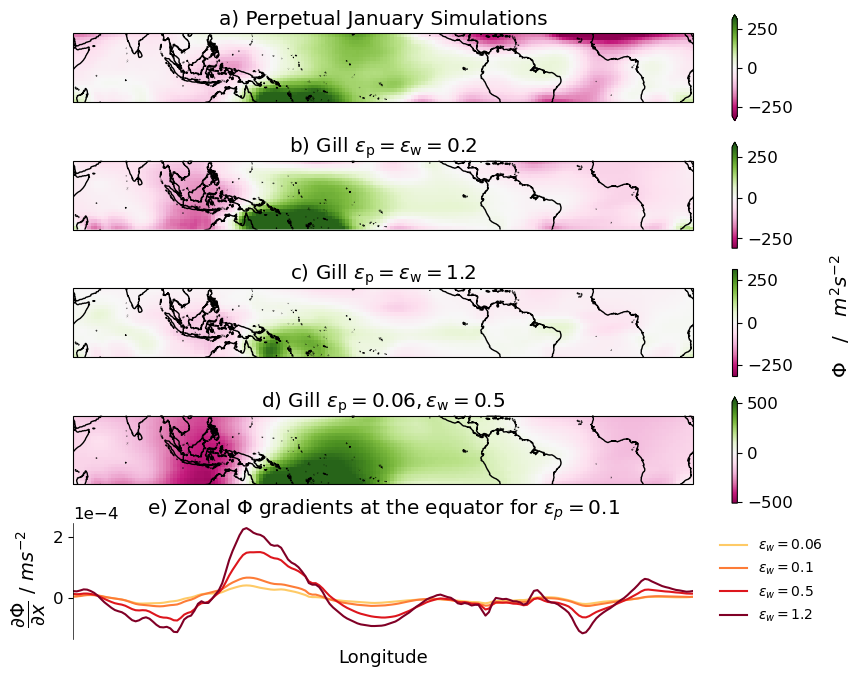

In [52]:
fig,xs = plt.subplots(5,1,figsize=(10,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)},facecolor="white")

ax = xs[0]
im =  dap_diff_an_LR["400_150_thick"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,cbar_kwargs={"label": " "},vmin=-310,vmax=310,transform=ccrs.PlateCarree())
ax.set_title("a) Perpetual January Simulations")
metcalc.set_regional_cartopy(ax)

ax = xs[1]
epsilon_p = 0.2
epsilon_w = 0.2
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-310,vmax=310,cbar_kwargs={"label":""},transform=ccrs.PlateCarree())
ax.set_title(f"b) Gill $  \epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p} $")
metcalc.set_regional_cartopy(ax)

ax = xs[2]
epsilon_p = 1.2
epsilon_w = 1.2
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-310,vmax=310,cbar_kwargs={"label":""},transform=ccrs.PlateCarree())
ax.set_title(f"c) Gill $  \epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p} $")
metcalc.set_regional_cartopy(ax)

ax = xs[3]
epsilon_p = 0.06
epsilon_w = 0.5
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-510,vmax=510,cbar_kwargs={"label":""},transform=ccrs.PlateCarree())
ax.set_title(f"d) Gill $ \epsilon_\mathrm{{p}} = {epsilon_p} , \epsilon_\mathrm{{w}} = {epsilon_w}$")
metcalc.set_regional_cartopy(ax)

ax=xs[4]
metcalc.remove_axes(ax)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

ax = fig.add_subplot(515)

epsilons_plot = [0.06,0.1,0.5,1.2]
cmap = plt.cm.YlOrRd
evenly_spaced_interval = np.linspace(0.3, 1, len(epsilons_plot))

colors = [cmap(x) for x in evenly_spaced_interval]
for i, e in enumerate(epsilons_plot) :
    grad1 = delta_p_ep01_FFT["dp/dx"].sel(lat=slice(-2,2),epsilon_wind=e).mean("lat").sel(lon=slice(42,180)).values
    grad2 = delta_p_ep01_FFT["dp/dx"].sel(lat=slice(-2,2),epsilon_wind=e).mean("lat").sel(lon=slice(-180,42)).values
    ax.plot(np.linspace(1,359,180),np.concatenate([grad1,grad2]),color=colors[i],label=f"$\epsilon_w = ${e}")


metcalc.remove_axes(ax)
ax.set_xlabel("Longitude",size=13)
ax.set_ylabel(" $ \dfrac{ \partial \Phi }{ \partial x} \ / \ m s^{-2} $ ",size=14)
ax.set_title("e) Zonal $\Phi$ gradients at the equator for $\epsilon_p = 0.1$")
ax.legend(frameon=False,loc='center right', bbox_to_anchor=(1.23, 0.5),fontsize=10)
box = ax.get_position()
ax.set_position([box.x0, box.y0-0.01, box.width * 0.8, box.height*1.09])
ax.set_xticks([])
ax.set_xlim(1,359)
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax.spines["bottom"].set_visible(False)

fig.supylabel(" $ \Phi \quad / \quad m^2 s^{-2} $", x=0.88,y=0.5)


plt.savefig('../plots/figure4_an.png', dpi=600,bbox_inches='tight')



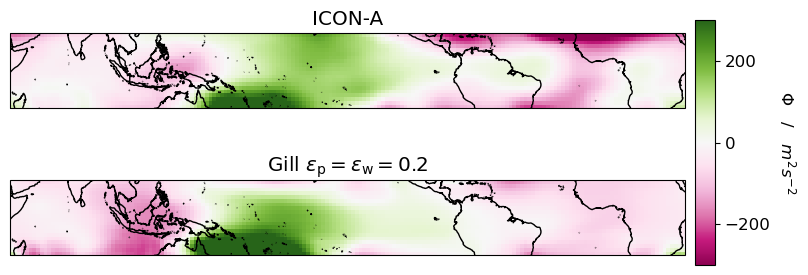

In [53]:
fig,xs = plt.subplots(2,1,figsize=(10,3.5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)},facecolor="white")

ax = xs[0]
im =  dap_diff_an_LR["400_150_thick"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-300,vmax=300,transform=ccrs.PlateCarree())
contor = dap_diff_an_LR.coarsen(lon=5, lat=5).mean()
#ax.contour(contor.lon.values, contor.lat.values, contor["400_200_thick"], [0],colors="black")
ax.set_title("ICON-A")
metcalc.set_regional_cartopy(ax)

ax = xs[1]
epsilon_p = 0.2
epsilon_w = 0.2
im =  delta_p_FFT_an_phi.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-300,vmax=300,transform=ccrs.PlateCarree())
ax.set_title(f"Gill $  \epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p} $")
metcalc.set_regional_cartopy(ax)

metcalc.good_colorbar(im,fig,"$ \Phi \quad / \quad m^2 s^{-2} $",cb_kwargs={"ticks" : [-200,0,200]})

plt.savefig('../plots/figure_graphical_abstract.png', dpi=600,bbox_inches='tight')



### Compare to 700-200

Text(0.88, 0.5, ' $ \\Phi \\quad / \\quad m^2 s^{-2} $')

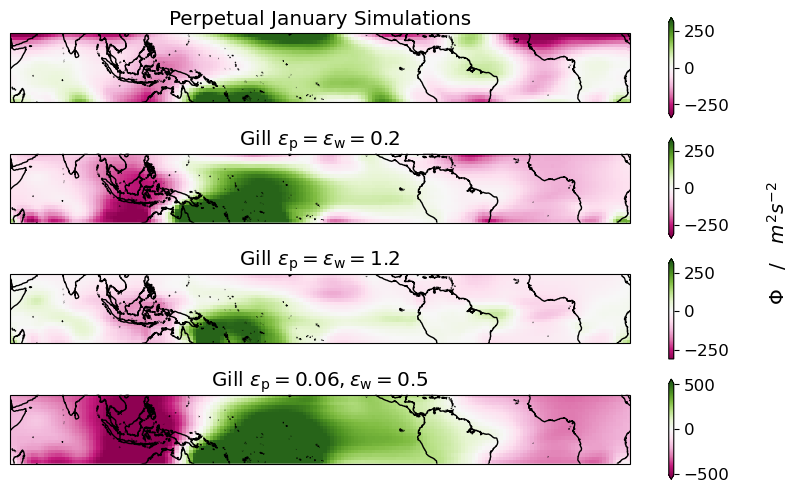

In [54]:
fig,xs = plt.subplots(4,1,figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)},facecolor="white")

ax = xs[0]
im =  dap_diff_an_LR["700_200_thick"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,cbar_kwargs={"label": " "},vmin=-310,vmax=310,transform=ccrs.PlateCarree())
ax.set_title("Perpetual January Simulations")
metcalc.set_regional_cartopy(ax)

ax = xs[1]
epsilon_p = 0.2
epsilon_w = 0.2
im =  delta_p_FFT_an_phi_700.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-310,vmax=310,cbar_kwargs={"label":""},transform=ccrs.PlateCarree())
ax.set_title(f"Gill $  \epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p} $")
metcalc.set_regional_cartopy(ax)

ax = xs[2]
epsilon_p = 1.2
epsilon_w = 1.2
im =  delta_p_FFT_an_phi_700.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-310,vmax=310,cbar_kwargs={"label":""},transform=ccrs.PlateCarree())
ax.set_title(f"Gill $  \epsilon_\mathrm{{p}} = \epsilon_\mathrm{{w}} = {epsilon_p} $")
metcalc.set_regional_cartopy(ax)

ax = xs[3]
epsilon_p = 0.06
epsilon_w = 0.5
im =  delta_p_FFT_an_phi_700.sel(epsilon_wind=epsilon_w,epsilon_pre=epsilon_p)["p"].plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=True,vmin=-510,vmax=510,cbar_kwargs={"label":""},transform=ccrs.PlateCarree())
ax.set_title(f"Gill $ \epsilon_\mathrm{{p}} = {epsilon_p} , \epsilon_\mathrm{{w}} = {epsilon_w}$")
metcalc.set_regional_cartopy(ax)

fig.supylabel(" $ \Phi \quad / \quad m^2 s^{-2} $", x=0.88,y=0.5)



## Special Sims

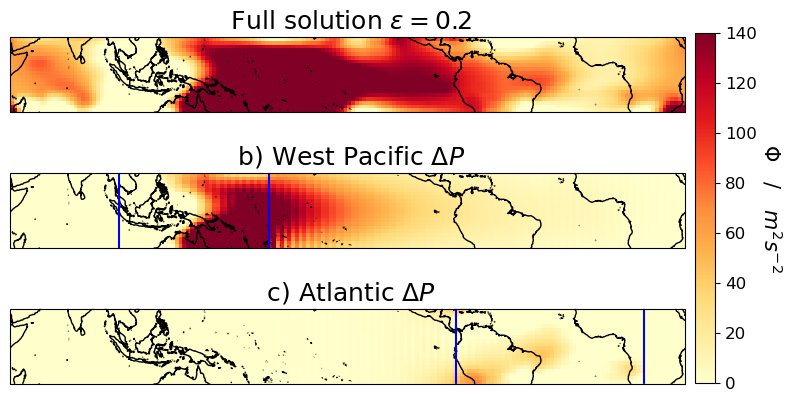

In [55]:
fig,xs = plt.subplots(3,1,figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)},facecolor="white")

clim=140
e = 0.2

ax = xs[0]
sim = delta_p_FFT.sel(epsilon_pre=e,epsilon_wind=e)*2800.
im =  sim["p"].plot(x="lon",y="lat",ax=ax,cmap='YlOrRd',add_colorbar=False,vmin=0,vmax=clim,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax)
ax.set_title(" Full solution $\epsilon = 0.2$",size=18)


ax = xs[1]
sim = delta_p_wpac.sel(epsilon_pre=e,epsilon_wind=e)*2800.
im =  sim["p"].plot(x="lon",y="lat",ax=ax,cmap='YlOrRd',add_colorbar=False,vmin=0,vmax=clim,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax)
ax.set_title(" b) West Pacific $ \Delta P $",size=18)

ax.plot([100,100], [-20,20], color='blue', transform=ccrs.PlateCarree())
ax.plot([180,180], [-20,20], color='blue', transform=ccrs.PlateCarree())

ax = xs[2]
sim = delta_p_atl.sel(epsilon_pre=e,epsilon_wind=e)*2800.
im =  sim["p"].plot(x="lon",y="lat",ax=ax,cmap='YlOrRd',add_colorbar=False,vmin=0,vmax=clim,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax)
ax.set_title(" c) Atlantic $ \Delta P $",size=18)

ax.plot([-80,-80], [-20,20], color='blue', transform=ccrs.PlateCarree())
ax.plot([20,20], [-20,20], color='blue', transform=ccrs.PlateCarree())

metcalc.good_colorbar(im,fig,"$ \Phi \quad / \quad m^2 s^{-2} $",label_kwargs={"labelpad" : 20, "size" : 15})

plt.savefig('../plots/figure7.png', dpi=600,bbox_inches='tight')


## Idealised Solution

In [56]:
idealised_p = xr.open_dataset(f"{GILL_DIR}/combined_solution_epsilon_p=0.1_epsilon_u=0.1_epsilon_v=0.1_f=gill_res=0.5.nc")
idealised_Q = xr.open_dataset(f"{GILL_DIR}/combined_solution_Q_epsilon_p=0.1_epsilon_u=0.1_epsilon_v=0.1_f=gill_res=0.5.nc")

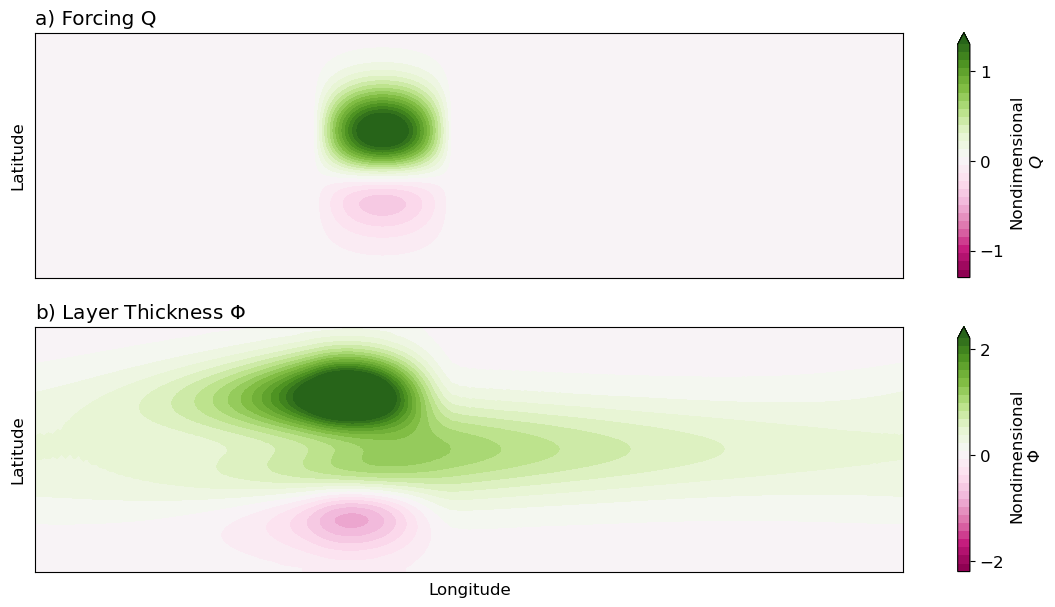

In [57]:
fig,xs = plt.subplots(2,1,figsize=(14,7),sharex=True,facecolor="white")
ax=xs[0]
idealised_Q.p.plot.contourf(x="x",y="y",ax=xs[0],cmap="PiYG",vmin=-1.3,vmax=1.3,levels=30,cbar_kwargs={"label":"Nondimensional\n$Q$","ticks":[-1, 0, 1]})
ax.set_xlabel("")
ax.set_ylabel("Latitude")
ax.set_yticks([])
ax.set_title("a) Forcing Q",loc="left")

ax=xs[1]
idealised_p.p.plot.contourf(x="x",y="y",ax=xs[1],cmap="PiYG",vmin=-2.2,vmax=2.2,levels=30,cbar_kwargs={"label":"Nondimensional\n$\Phi$","ticks":[-2, 0, 2]})
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("b) Layer Thickness $\Phi$",loc="left")

plt.savefig('../plots/idealised_forcing.png', dpi=600,bbox_inches='tight')
